In [15]:
import base64, os
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List, TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [16]:
from dotenv import load_dotenv
load_dotenv() 
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)
model.invoke([HumanMessage("Hello, how are you?")])

AIMessage(content='I am doing well, thank you for asking!  How are you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run-346f0b09-7061-48c6-97b7-a4115578033e-0', usage_metadata={'input_tokens': 6, 'output_tokens': 17, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})

In [17]:
class AgentState(TypedDict):
    # The document provided
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [18]:
vision_llm = model

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.
    
    Master Wayne often leaves notes with his training regimen or meal plans.
    This allows me to properly analyze the contents.
    """
    all_text = ""
    try:
        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # A butler should handle errors gracefully
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

def divide(a: int, b: int) -> float:
    """Divide a and b - for Master Wayne's occasional calculations."""
    return a / b

# Equip the butler with tools
tools = [
    divide,
    extract_text
]

llm = model
llm_with_tools = llm.bind_tools(tools)

In [19]:
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are a helpful butler named Alfred that serves Mr. Wayne and Batman. You can analyse documents and run computations with provided tools:\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded image is: {image}")

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
        "input_file": state["input_file"]
    }

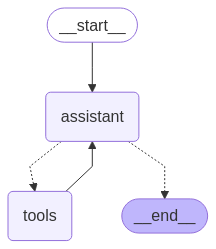

In [20]:
# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [21]:
messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke({"messages": messages, "input_file": None})

# Show the messages
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (9d01c1de-4e46-49c1-b1d9-941ab521ad03)
 Call ID: 9d01c1de-4e46-49c1-b1d9-941ab521ad03
  Args:
    b: 5.0
    a: 6790.0
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

The answer is 1358.


In [ ]:
messages = [HumanMessage(content="According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?")]
messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})


for m in messages['messages']:
    m.pretty_print()


In [ ]:
langfuse_pk = os.getenv("LANGFUSE_PUBLIC_KEY")
langfuse_sk = os.getenv("LANGFUSE_SECRET_KEY")
os.environ["LANGFUSE_PUBLIC_KEY"] = langfuse_pk
os.environ["LANGFUSE_SECRET_KEY"] = langfuse_sk
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # 

from langfuse.callback import CallbackHandler
langfuse_handler = CallbackHandler()


messages = [HumanMessage(content="According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?")]
messages = react_graph.invoke(input={"messages": messages, "input_file": "Batman_training_and_meals.png"},config={"callbacks": [langfuse_handler]} )


for m in messages['messages']:
    m.pretty_print()




================================ Human Message =================================

According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?
================================== Ai Message ==================================
Tool Calls:
  extract_text (cb98f15d-65c4-46c9-a528-06b542379292)
 Call ID: cb98f15d-65c4-46c9-a528-06b542379292
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

SUNDAY 2/20
MORNING
30 minute jog
30 minute meditation
EVENING
clean and jerk lifts - 3 reps/8 sets. 262 lbs.
5 sets metabolic conditioning:
1½ mile run
21 kettlebell swings
12 pull-ups
30 minutes flexibility
30 minutes sparring
MONDAY 2/21
MORNING
30 minute jog
EVENING
30 minutes traditional kata (focus on Japanese forms)
5 sets 20 foot rope climb
30 minutes gymnastic rings (work on muscle ups in
particular)
high box jumps-12 reps/8 sets
c